# Recoinize

# 1. Setup

## 1.1. Pull code from GitHub

In [123]:
!git fetch --all
 
# Switch to the "live-edit" branch, ignore local changes, and pull the latest changes
!git checkout live-edit
!git reset --hard
!git pull

Fetching origin
remote: Enumerating objects: 5, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 3 (delta 1), reused 3 (delta 1), pack-reused 0
Unpacking objects: 100% (3/3), 712.33 KiB | 180.00 KiB/s, done.
From https://github.com/photonsquid/Recoinize
   0dc08c4..6fb7341  live-edit  -> origin/live-edit
Already on 'live-edit'
Your branch is behind 'origin/live-edit' by 1 commit, and can be fast-forwarded.
  (use "git pull" to update your local branch)
HEAD is now at 0dc08c4 auto: update dataset.py
Updating 0dc08c4..6fb7341
Fast-forward
 main.ipynb | 228 +++++++++++++++++++++++++++----------------------------------
 1 file changed, 102 insertions(+), 126 deletions(-)


ss


In [124]:
!nvidia-smi

Thu Jan 19 12:44:08 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.73.05    Driver Version: 510.73.05    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro P5000        Off  | 00000000:00:05.0 Off |                  Off |
| 26%   29C    P8     5W / 180W |   1297MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## 1.2. Define constants

Settings are in the top of the notebook, so you can easily change them.

## 1.3. Install dependencies

In [125]:
from helpers.install import install_requirements

# install_requirements()

## 1.4. Import dependencies

In [126]:
# Import standard dependencies
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

# Import tensorflow dependencies - Functional API
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
from keras.models import Sequential, load_model, Model


## 1.5 Set GPU Growth

In [127]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

# 2. Get data

This folder names are defined in our script (cf. this [repo](https://github.com/photonsquid/Recoinize-generator)) that generates the dataset.
Then it is uploaded to our [Hugging Face dataset](https://huggingface.co/datasets/photonsquid/coins-euro).

In [128]:
ROOT_PATH = "data/tests"
TRAIN_PATH = "train"
TEST_PATH = "test"

train_path = os.path.join(ROOT_PATH, TRAIN_PATH)
test_path = os.path.join(ROOT_PATH, TEST_PATH)


def load_dataset(path):
    images = []
    labels = []

    for image_name in os.listdir(path):
        image = cv2.imread(os.path.join(path, image_name))
        image = cv2.resize(image, (105, 105))
        images.append(image)

        # remove the extension from the image name
        label = image_name.split(".")[0]
        # get the country, coin_value, specificity and id
        label = label.split("_")
        country = label[0]
        coin_value = label[1]
        id = label[-1]
        # specificity is all other elements
        specificity = "_".join(label[2:-1])

        labels.append({
            "country": country,
            "coin_value": coin_value,
            "specificity": specificity,
            "id": id
        })

    return images, labels


In [129]:
# import imagrs into a tensor flow dataset
train_images, train_labels = load_dataset(train_path)
test_images, test_labels = load_dataset(test_path)

# convert the images to numpy arrays
train_images = np.array(train_images)
test_images = np.array(test_images)

# normalize the images
train_images = train_images / 255.0
test_images = test_images / 255.0

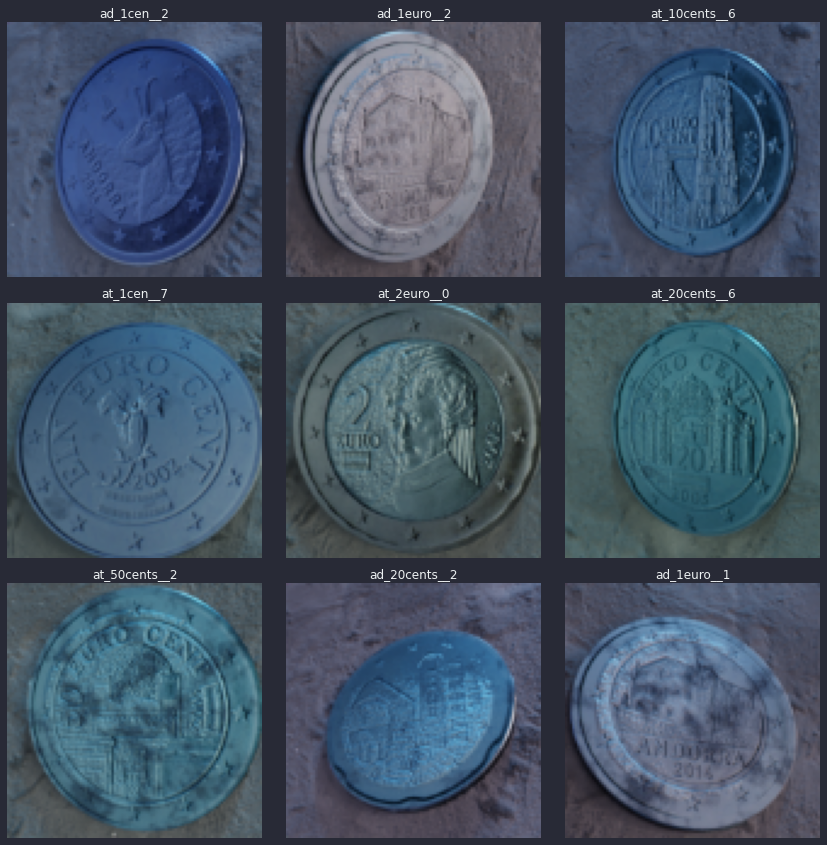

In [130]:
# from train dataset, show in a grid 3x3 images randomly selected, with the label on the top
fig, axs = plt.subplots(3, 3, figsize=(15, 15))
# set small space between images
fig.subplots_adjust(hspace=0.1, wspace=0)
# set background color
fig.patch.set_facecolor('#282A36') # type: ignore
# set color of the text
plt.rcParams['text.color'] = '#ecf0f1'  # type: ignore

for i in range(3):
    for j in range(3):
        # select a random image
        index = random.randint(0, len(train_images))
        image = train_images[index]
        label = train_labels[index]
        label = f"{label['country']}_{label['coin_value']}_{label['specificity']}_{label['id']}"
        # show the image
        axs[i, j].imshow(image) # type: ignore
        axs[i, j].set_title(label)  # type: ignore
        # remove the axis
        axs[i, j].axis("off")  # type: ignore

In [136]:


def preprocess_image(image):
    # load the image
    image = tf.io.read_file(image)
    # decode the image
    image = tf.image.decode_png(image, channels=3)
    # resize the image
    image = tf.image.resize(image, [105, 105])
    # normalize the image
    image = image / 255.0 # type: ignore

    return image

def preprocess_triplet(anchor, positive, negative):
    # preprocess the images
    anchor = preprocess_image(anchor)
    positive = preprocess_image(positive)
    negative = preprocess_image(negative)

    return anchor, positive, negative

def create_triplets(image):
    # get the label of the image
    # label pattern: country_coin_value_specificity_id
    label = image.numpy().decode("utf-8").split("_")
    country = label[0]
    coin_value = label[1]
    id = label[-1]
    # specificity is all other elements
    specificity = "_".join(label[2:-1])



    # get the path of the image
    image = image.numpy().decode("utf-8")
    # get the path of the folder
    folder = os.path.dirname(image)
    # get the path of the anchor image
    anchor_image = image
    
    # to get the positive image, we need to find an image with the same country, coin_value and specificity, but different id
    positive_image = None
    count = 0
    while positive_image is None and count < 100:
        # get a random image
        random_image = random.choice(os.listdir(folder))
        # get the label of the random image
        random_label = random_image.split("_")
        random_country = random_label[0]
        random_coin_value = random_label[1]
        random_id = random_label[-1]
        # specificity is all other elements
        random_specificity = "_".join(random_label[2:-1])

        # check if the image has the same country, coin_value and specificity, but different id
        if random_country == country and random_coin_value == coin_value and random_specificity == specificity and random_id != id:
            positive_image = os.path.join(folder, random_image)
        count += 1

    # to get the negative image, we need to find an image with a different country, coin_value and specificity
    negative_image = None
    count = 0
    while negative_image is None and count < 100:
        # get a random image
        random_image = random.choice(os.listdir(folder))
        # get the label of the random image
        random_label = random_image.split("_")
        random_country = random_label[0]
        random_coin_value = random_label[1]
        random_id = random_label[-1]
        # specificity is all other elements
        random_specificity = "_".join(random_label[2:-1])

        # check if the image has a different country, coin_value and specificity
        if random_country != country and random_coin_value != coin_value and random_specificity != specificity:
            negative_image = os.path.join(folder, random_image)
        count += 1
    
    

    return anchor_image, positive_image, negative_image


In [140]:
# create a dataset with all the images
dataset = tf.data.Dataset.list_files(train_path, "/*.png")
# create a dataset with all the triplets
triplets = dataset.map(lambda x: tf.py_function(create_triplets, [x], [tf.string, tf.string, tf.string]), num_parallel_calls=tf.data.experimental.AUTOTUNE)
# preprocess the triplets
triplets = triplets.map(lambda x, y, z: tf.py_function(preprocess_triplet, [x, y, z], [tf.float32, tf.float32, tf.float32]), num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [142]:
# check the first triplet
for anchor, positive, negative in triplets.take(1):
    # show the images
    fig, axs = plt.subplots(1, 3, figsize=(15, 15))
    # set small space between images
    fig.subplots_adjust(hspace=0.1, wspace=0)
    # set background color
    fig.patch.set_facecolor('#282A36') # type: ignore
    # set color of the text
    plt.rcParams['text.color'] = '#ecf0f1'  # type: ignore

    axs[0].imshow(anchor) # type: ignore
    axs[0].set_title("Anchor")  # type: ignore
    # remove the axis
    axs[0].axis("off")  # type: ignore

    axs[1].imshow(positive) # type: ignore
    axs[1].set_title("Positive")  # type: ignore
    # remove the axis
    axs[1].axis("off")  # type: ignore

    axs[2].imshow(negative) # type: ignore
    axs[2].set_title("Negative")  # type: ignore
    # remove the axis
    axs[2].axis("off")  # type: ignore

2023-01-19 12:46:29.060660: W tensorflow/core/framework/op_kernel.cc:1818] UNKNOWN: IndexError: list index out of range
Traceback (most recent call last):

  File "/usr/local/lib/python3.9/dist-packages/tensorflow/python/ops/script_ops.py", line 269, in __call__
    return func(device, token, args)

  File "/usr/local/lib/python3.9/dist-packages/tensorflow/python/ops/script_ops.py", line 147, in __call__
    outputs = self._call(device, args)

  File "/usr/local/lib/python3.9/dist-packages/tensorflow/python/ops/script_ops.py", line 154, in _call
    ret = self._func(*args)

  File "/usr/local/lib/python3.9/dist-packages/tensorflow/python/autograph/impl/api.py", line 642, in wrapper
    return func(*args, **kwargs)

  File "/tmp/ipykernel_504/829788618.py", line 26, in create_triplets
    coin_value = label[1]

IndexError: list index out of range




UnknownError: {{function_node __wrapped__IteratorGetNext_output_types_3_device_/job:localhost/replica:0/task:0/device:CPU:0}} IndexError: list index out of range
Traceback (most recent call last):

  File "/usr/local/lib/python3.9/dist-packages/tensorflow/python/ops/script_ops.py", line 269, in __call__
    return func(device, token, args)

  File "/usr/local/lib/python3.9/dist-packages/tensorflow/python/ops/script_ops.py", line 147, in __call__
    outputs = self._call(device, args)

  File "/usr/local/lib/python3.9/dist-packages/tensorflow/python/ops/script_ops.py", line 154, in _call
    ret = self._func(*args)

  File "/usr/local/lib/python3.9/dist-packages/tensorflow/python/autograph/impl/api.py", line 642, in wrapper
    return func(*args, **kwargs)

  File "/tmp/ipykernel_504/829788618.py", line 26, in create_triplets
    coin_value = label[1]

IndexError: list index out of range


	 [[{{node EagerPyFunc}}]] [Op:IteratorGetNext]

In [ ]:
train_data = triplets.batch(16)
train_data = train_data.prefetch(8)

In [ ]:
def make_embedding():
    inp = Input(shape=(105, 105, 3), name='input_image')

    # First block
    c1 = Conv2D(64, (10, 10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2, 2), padding='same')(c1)

    # Second block
    c2 = Conv2D(128, (7, 7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2, 2), padding='same')(c2)

    # Third block
    c3 = Conv2D(128, (4, 4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2, 2), padding='same')(c3)

    # Final embedding block
    c4 = Conv2D(256, (4, 4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)

    return Model(inputs=[inp], outputs=[d1], name='embedding')


In [ ]:
embedding = make_embedding()
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 105, 105, 3)]     0         
                                                                 
 conv2d_8 (Conv2D)           (None, 96, 96, 64)        19264     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 48, 48, 64)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 42, 42, 128)       401536    
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 21, 21, 128)      0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 18, 18, 128)       26

In [ ]:
class L1Dist(Layer):

    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()

    # Magic happens here - similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)



In [ ]:
def make_siamese_model():

    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(105, 105, 3))

    # Validation image in the network
    validation_image = Input(name='validation_img', shape=(105, 105, 3))

    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image),
                              embedding(validation_image))

    # Classification layer
    classifier = Dense(1, activation='sigmoid')(distances)

    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')


In [ ]:
siamese_model = make_siamese_model()
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 105, 105, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 105, 105, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

In [ ]:
binary_cross_loss = tf.losses.BinaryCrossentropy()
opt = tf.keras.optimizers.Adam(1e-4)  # 0.0001

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)


@tf.function
def train_step(batch):

    # Record all of our operations
    with tf.GradientTape() as tape:
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]

        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)

    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)

    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))

    # Return loss
    return loss

# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall


def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))

        # Creating a metric object
        r = Recall()
        p = Precision()

        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            loss = train_step(batch)
            yhat = siamese_model.predict(batch[:2])
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat)
            progbar.update(idx+1)
        print(loss.numpy(), r.result().numpy(), p.result().numpy())

        # Save checkpoints
        if epoch % 10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)


EPOCHS = 50



In [ ]:
train(train_data, EPOCHS)


 Epoch 1/50
tf.Tensor(b'data/tests/train', shape=(), dtype=string)


2023-01-19 12:42:57.837078: W tensorflow/core/framework/op_kernel.cc:1818] UNKNOWN: IndexError: list index out of range
Traceback (most recent call last):

  File "/usr/local/lib/python3.9/dist-packages/tensorflow/python/ops/script_ops.py", line 269, in __call__
    return func(device, token, args)

  File "/usr/local/lib/python3.9/dist-packages/tensorflow/python/ops/script_ops.py", line 147, in __call__
    outputs = self._call(device, args)

  File "/usr/local/lib/python3.9/dist-packages/tensorflow/python/ops/script_ops.py", line 154, in _call
    ret = self._func(*args)

  File "/usr/local/lib/python3.9/dist-packages/tensorflow/python/autograph/impl/api.py", line 642, in wrapper
    return func(*args, **kwargs)

  File "/tmp/ipykernel_504/1450700064.py", line 27, in create_triplets
    coin_value = label[1]

IndexError: list index out of range




UnknownError: {{function_node __wrapped__IteratorGetNext_output_types_3_device_/job:localhost/replica:0/task:0/device:CPU:0}} IndexError: list index out of range
Traceback (most recent call last):

  File "/usr/local/lib/python3.9/dist-packages/tensorflow/python/ops/script_ops.py", line 269, in __call__
    return func(device, token, args)

  File "/usr/local/lib/python3.9/dist-packages/tensorflow/python/ops/script_ops.py", line 147, in __call__
    outputs = self._call(device, args)

  File "/usr/local/lib/python3.9/dist-packages/tensorflow/python/ops/script_ops.py", line 154, in _call
    ret = self._func(*args)

  File "/usr/local/lib/python3.9/dist-packages/tensorflow/python/autograph/impl/api.py", line 642, in wrapper
    return func(*args, **kwargs)

  File "/tmp/ipykernel_504/1450700064.py", line 27, in create_triplets
    coin_value = label[1]

IndexError: list index out of range


	 [[{{node EagerPyFunc}}]] [Op:IteratorGetNext]

## 3. Build the model

Let's say that here we have a clean Tensorflow dataset:
    
- `train_ds` is the training dataset
- `test_ds` 
- `val_ds` is the validation dataset
  
Each dataset is a `tf.data.Dataset` object.

we also have Anchor, Positive and Negative images.

### 3.1 The embedding model